# This notebooks does predictive modeling of the Output : "Is there any cook step by the consumer?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [10]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [11]:
#filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
filename1 = "C:/Pepsico/Base LCS Files Extract_28 Aug 2019_207Files.xlsm"
filename2 = "C:/Pepsico/Cook step_21 Files_Extracts 03 Sep 2019.xlsm"

# Read the extract file, check the number of records, first few rows

In [12]:
df1 = pd.read_excel(filename1)
df2 = pd.read_excel(filename2)

In [13]:
df =  pd.concat([df1,df2])

In [14]:
len(df)

228

In [15]:
df.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,prodModifications,newIngredient,approvedPackage,potentialMicrobial,crossContactAllergens,chokeHazard,operationalAllergen,abuseByConsumer,cookstepByConsumer,allergensLabeledIMAF
0,FSHA 46694 Lays Ridge.xlsm,Lays Ridge launch,46694,"Lay's Wavy Spring Onion, Lay's Wavy Sour Cream,",Category Reframe,Significant launch of new subline within exist...,"P02806, PP03084 (PF03211)","Artur Zyśk, +48723990114",ESSA,"Warsaw, Poland",...,No,Yes,No,No,Yes,No,Yes,No,No,"Milk, Lactose : Milk, Lactose"
1,FSHA 5.4.1 - Doritos Sweet Chilli Pepper Na Re...,Sodium reduction Doritos Sweet Chilli Pepper I...,39660,Doritos Sweet Chilli Pepper,Refresh,Sodium reduction project to conform to Legisla...,999010432 Doritos Sweet Chilli Pepper,Sherwin Tlhoaele / Gabisile Buthelezi,ESSA,South Africa,...,No,No,No,No,No,No,Yes,No,No,Not Applicable : Not Applicable : Soya
2,FSHA 5.4.1 - Doritos Sweet Chilli Pepper Na Re...,Sodium reduction Doritos Sweet Chilli Pepper P...,39660,Doritos Sweet Chilli Pepper,Refresh,Sodium reduction project to conform to Legisla...,999010432 Doritos Sweet Chilli Pepper,Sherwin Tlhoaele / Gabisile Buthelezi,ESSA,South Africa,...,No,No,No,No,No,No,Yes,No,No,Not Applicable : Not Applicable : Soya
3,FSHA 5.4.1 - Lay's BBQ Gate 3 Prospecton 5.04....,Lay's Barbecue Flavoured Potato Chips,50169,Lay's Barbecue Flavoured Potato Chips,Refresh,New flavour for the Lay's range - Lay's Barbecue,not provided,Xolelwa Nzuzo,ESSA,South Africa,...,No,Yes,No,No,Yes,No,Yes,No,No,Not Applicable : Not Applicable
4,FSHA 5.4.1 - Simba Cheese & Onion NA Reduction...,Simba Cheese & Onion Sodium Reduction Isando,39660,Simba Cheese & Onion,Renovation,Sodium Reduction Project to conform to Legisla...,Simba Potato Chips (ZBR for different flavoure...,Lizel Laubscher,ESSA,South Africa,...,No,No,No,No,Yes,No,Yes,No,No,Not Applicable : Not Applicable : Dairy (Cows ...


# Select key features for cookstep 

In [16]:

features_df=df[['projDesc','CPD-ProdName','cookedOrHeated','labelingInstructions','CPD-ProdName-Desc','packMaterial']]

#Replace missing values with NA
df.fillna('NA', inplace=True)

In [17]:
#Convert all text to string and lower case, since some values are coming as float from data extract
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)  
features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))    
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName']=features_df['CPD-ProdName'].apply(lambda x:conv_str(x)) 
features_df['cookedOrHeated']=features_df['cookedOrHeated'].apply(lambda x:conv_str(x))
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x))
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))
 

# Concatenate the columns as one single text value

In [18]:
features_df['concat_text'] = features_df['projDesc']+" "+features_df['CPD-ProdName-Desc']+" "+features_df['CPD-ProdName']+" "+features_df['cookedOrHeated']+" "+features_df['labelingInstructions']+" "+features_df['packMaterial']

# Find the number of tokens in the text

In [19]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

13783

We have over 15k words in the data.

# Find the value counts of target Field (Yes / No)

In [20]:
df.cookstepByConsumer.value_counts()

No     204
Yes     21
NA       3
Name: cookstepByConsumer, dtype: int64

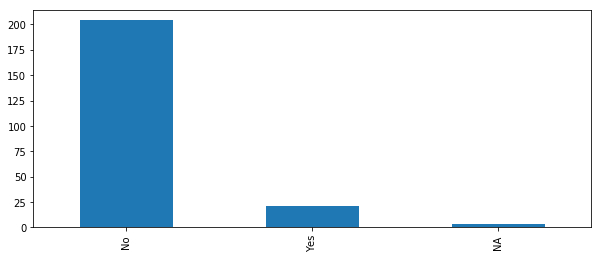

In [21]:
plt.figure(figsize=(10,4))
df.cookstepByConsumer.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [22]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):

        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [23]:
features_df["tags"] = impute_target(df,"cookstepByConsumer")

# Plot the target after binarization

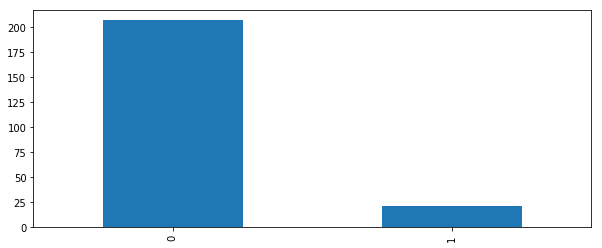

In [24]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [25]:
#Check the counts of 1 and 0 in the target
features_df.tags.value_counts()

0    207
1     21
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [26]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [27]:
print_plot(10)

sodium reduction project to conform to legislative requirements in south africa. there are no new hazard or allergens being introduced to the plant.  the seasoning does not require the process to be modified.  the packaging material and pack format remain as per current. ready to eat snack - potato chips simba creamy cheddar ruffles potato chips no - ready to eat snack store in a cool dry place existing film construction
Tag: 0


In [28]:
print_plot(5)

sodium reduction project to conform to legislative requirements in south africa. there are no new hazard or allergens being introduced to the plant.  the seasoning does not require the process to be modified.  the packaging material and pack format remain as per current. ready to eat snack - potato chips simba cheese & onion ruffles potato chips no - ready to eat snack store in a cool dry place existing film construction
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [29]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
stop = stopwords.words('english')
stop.extend(['na','n', 'none'])
STOPWORDS=set(stop)

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [30]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [31]:
print_plot(5)

sodium reduction project conform legislative requirements south africa new hazard allergens introduced plant seasoning require process modified packaging material pack format remain per current ready eat snack potato chips simba cheese onion ruffles potato chips ready eat snack store cool dry place existing film construction
Tag: 0


In [32]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

9431

We see 9k words after cleaning and lowercasing the text

# Train Test Split

In [33]:
len(features_df)

228

In [34]:
# We do a 80 20 split of the data into Train and Test samples. We set aside the Test samples for validation of the model
# We ensure the same distribution of the 0 and 1 is maintained in both train and test by specifying stratify=y
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [35]:
len(X_train)

182

In [36]:
len(X_test)

46

In [37]:
y_train.value_counts()

0    165
1     17
Name: tags, dtype: int64

In [38]:
y_test.value_counts()

0    42
1     4
Name: tags, dtype: int64

In [39]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [40]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_cookstepByConsumer = X[X.tags==0]
cookstepByConsumer = X[X.tags==1]

In [41]:
len(not_cookstepByConsumer)

165

In [42]:
len(cookstepByConsumer)

17

In [43]:
# upsample minority
cookstepByConsumer_upsampled = resample(cookstepByConsumer,
                          replace=True, # sample with replacement
                          n_samples=len(not_cookstepByConsumer), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([cookstepByConsumer_upsampled, not_cookstepByConsumer])

In [44]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    165
0    165
Name: tags, dtype: int64

In [45]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [46]:
y_train=y_train.reshape(y_train.shape[0],1)

In [47]:
y_train.shape

(330, 1)

In [48]:
X_train.shape

(330, 1)

In [49]:
X_train['concat_text'].values[5]

'reducing long grain wild rice 25 increasing parboiled rice nonrte packaged goods eg pasta roni near east ricearoni groats grits pasta grains minor ingredients mixed without addition seasoning packet packaged final product near east roasted vegetable chicken pilaf yes final product considered rte product must undergo validated kill step prior human consumption yes validated consumer cook instructions package new packaging materials forms'

In [50]:
X_train = X_train['concat_text'].values

In [51]:
X_train[5]

'reducing long grain wild rice 25 increasing parboiled rice nonrte packaged goods eg pasta roni near east ricearoni groats grits pasta grains minor ingredients mixed without addition seasoning packet packaged final product near east roasted vegetable chicken pilaf yes final product considered rte product must undergo validated kill step prior human consumption yes validated consumer cook instructions package new packaging materials forms'

In [52]:
X_test.values[0]

'new seasoning plantno new allergens introducedflat pc base current plantpowder seasoningapproved supplier flat potato base lays sundried tomatogarlic iff 10933994 6 application nan nan nan'

In [53]:
X_test = X_test.values

In [54]:
X_test[0]

'new seasoning plantno new allergens introducedflat pc base current plantpowder seasoningapproved supplier flat potato base lays sundried tomatogarlic iff 10933994 6 application nan nan nan'

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [56]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 1.0
f1-score 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        42
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        46

Wall time: 13 ms


Let us check the index position in Actual Test samples and predicted values where the target is 1 (Yes for cookStep)

In [57]:
print(np.where(y_test==1))

(array([ 1, 15, 29, 41], dtype=int64),)


In [58]:
print(np.where(y_pred==1))

(array([ 1, 15, 29, 41], dtype=int64),)


We see these are matching, and so the accuracy scores given above are verified

In [59]:
X = np.concatenate((X_train,X_test))

In [60]:
len(X)

376

In [61]:
X=X.reshape(X.shape[0],)

In [62]:
y_test=y_test.reshape(y_test.shape[0],1)

In [63]:
y = np.concatenate((y_train,y_test))

In [64]:
y=y.reshape(y.shape[0],)

# Let us plot the Confustion matrix for cookstepByConsumer prediction

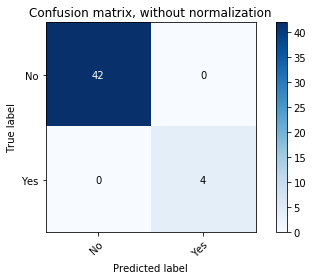

In [66]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [67]:
X = X.reshape(X.shape[0],)
y = y.reshape(y.shape[0],)

# In order to validate the results let us do K-fold CV with K set to 5

In [68]:
from sklearn.model_selection import cross_validate
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [69]:
print(cv_results['test_score'])

[1. 1. 1. 1. 1.]


This shows a healthy score in all folds <br>
Let us investigate the False Positives and False Negatives in the folds

In [70]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
#We define custom functions to return count of TP,TN,FP,FN for each fold
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,scoring=scoring, cv=cv)

In [71]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[38 36 35 28 36]
Count of True Negatives
[38 40 41 48 40]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[0 0 0 0 0]


# We can fine tune the parameters of Model using GridSearch, though in this case the default settings are giving use high accuracy

In [72]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',MultinomialNB() ),
])
#

In [73]:
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': ( 1, 2),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
   # 'clf__max_iter': (20,),
    'clf__alpha': (1, 0.8),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}
# multiprocessing requires the fork to happen in a __main__ protected
# block

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1, 0.8),
 'vect__max_df': (0.75, 1.0),
 'vect__min_df': (1, 2),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.9s finished


done in 22.628s

Best score: 1.000
Best parameters set:
	clf__alpha: 1
	vect__max_df: 0.75
	vect__min_df: 1
	vect__ngram_range: (1, 1)


# Let us check a few other models and evaluate the accuracy

### SGDClassifier

In [74]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [75]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        42
          1       1.00      0.75      0.86         4

avg / total       0.98      0.98      0.98        46

Wall time: 11.1 ms


### Logistic regression

In [76]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [77]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        42
          1       1.00      0.75      0.86         4

avg / total       0.98      0.98      0.98        46

Wall time: 10 ms


In [78]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),])
cv_results = cross_validate(lr.fit(X, y), X, y,scoring=scoring, cv=cv)

In [79]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[30 33 34 34 33]
Count of True Negatives
[46 42 42 42 43]
Count of False Negatives
[0 1 0 0 0]
Count of False Positives
[0 0 0 0 0]


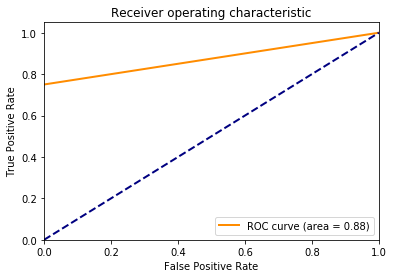

In [80]:
from sklearn.metrics import roc_curve, auc
true_labels = y_test
scores = y_pred

# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance plot using chi-square

In [81]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(features_df['concat_text'])
#X_tfidf_no = tfidf.fit_transform(train_df_no['all_cols'])
y= features_df["tags"]
#y_no = train_df_no['Target']
chi2score = chi2(X_tfidf, y)[0]
#chi2score_no = chi2(X_tfidf_no, y_no)[0]

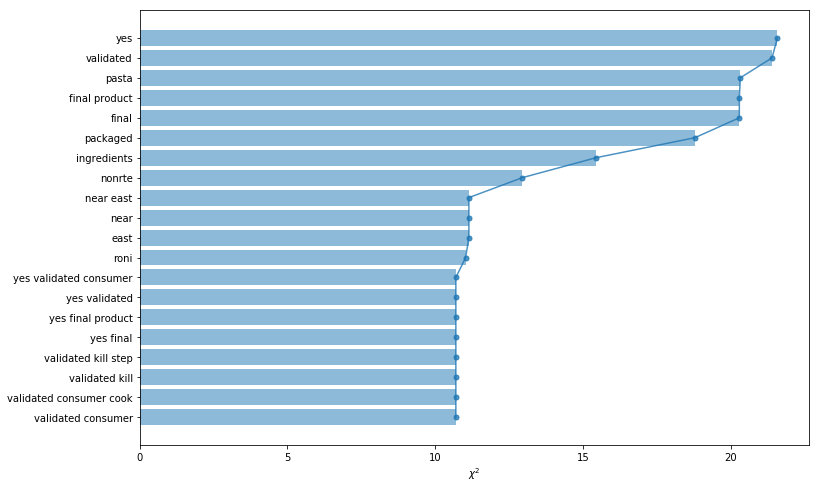

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
#print(scores)
chi2 = sorted(scores, key=lambda x:x[1])
#print(chi2)
topchi2 = list(zip(*chi2[-20:]))
#print(topchi2)
x = range(len(topchi2[1]))
#print(x)
labels = topchi2[0]
#print(labels)
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();